<h1><center>Сегментация изображений</center></h1>

<img src='https://drive.google.com/uc?export=view&id=14tXL-rgIASSAw9v5Sn4fkTsAs_Lq6hkW'>

## План занятия:

* Что такое сегментации изображений
* Методы сегментации
* Архитектура U-net
* Подготовка датасета
* Обучение модели
* Тестирование


<h1><center>Теория</center></h1>

На данный момент мы находимся в ситуации, когда глубокое обучение оказывается очень успешным при работе с изображениями как данными, и в настоящее время получается так, что оно во многих случаях работает даже лучше, чем люди. Наиболее важные проблемы, которыми люди интересовались в решении задач компьютерного зрения - классификация изображений, детекция объектов и сегментация.    
В результате решения задачи классификации мы хотим получить все классы объектов на изображении. В детектировании объектов мы идем на шаг дальше и работаем над локализацией объекта на изображении. В сегментации решается задача нахождения точной границы объекта на изображении.

## Что такое сегментация

Сегментация - это процесс, благодаря которому каждый пиксель изображения относится в определенный класс (попиксельная классификация). Существует два вида сегментаций: семантическая и инстанс-сегментация.   
Семантическая сегментация изображения означает присвоение каждому пикселю определенной метки. В этом заключается главное отличие от классификации, где всему изображению ставится в соответствие только одна метка. Сегментация работает со множеством объектов одного класса как с единым целым.   
Инстанс-сегментация делает тоже самое, но дополнительно обрабатывает каждый отдельный найденный объект одного класса как различные объекты. Решение задачи инстанс-сегментации сложнее, чем семантическая сегментация.

<img src='https://drive.google.com/uc?Export=view&id=1aTCg1SfYXRoeT0rfX5t2bALv9eW-nAwW'>

Для тренировки нейронных сетей решающих задачу сегментирования применяются свои специальные датасеты, в которых размечена маска изображения, например, такие как [PASCAL Visual Object Classes](http://host.robots.ox.ac.uk/pascal/VOC/) или [COCO (Common Objects in Context)](https://cocodataset.org/). Датасетов для сегментации меньше и они сложнее в составлении. Поэтому существует распространенная практика использования предобученнной нейронной сети, например, на ImageNet, в качестве части отвественной за восприятие объектов. Затем уже нейронная сеть доубучается на размеченных масках с помощью специальных датасетов.

Иногда маски не хранят в растровом представлении, а используют маску в закодированном в последовательность виде, к примеру, RLE (run-length encoding, кодирование длин серий) — алгоритм сжатия данных, заменяющий повторяющиеся символы (серии) на один символ и число его повторов. Серией называется последовательность, состоящая из нескольких одинаковых символов.
 

In [ ]:
def rle_decode(mask_rle, shape=(1080, 512, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    # print(s)
    # print(s[0:][::2], s[1:][::2])
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1

    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

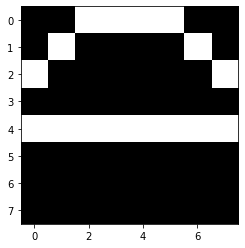

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


rle_string = '3 4 10 1 15 1 17 1 24 1 33 8'

mask = rle_decode(rle_string, shape=(8, 8))
plt.imshow(mask.reshape(8, 8), cmap='gray');

## Краткий обзор методов сегментации

Методы глубокого обучения позволяют добиваться хороших результатов в задаче семантической сегментации изображений. Здесь мы вкратце обсудим алгоритмы и популярные архитектуры моделей, которые применяются в решении задачи сегментации.


### Fully Convolutional Network

Одна из самых простых архитектур - это [FCN](https://towardsdatascience.com/review-fcn-semantic-segmentation-eb8c9b50d2d1) (Fully Convolutional Network). Это первая удачная попытка использования нейронной сети для задачи семантической сегментации. В этой архитектуре все слои сверточные. На выходе используется как правило один деконволюционный слой.
Одна из основных проблем - это низкое разрешение на выходе.

<img src='https://drive.google.com/uc?export=view&id=1-XxAqreNk-5p7Ak5sl4oIeCuaJ_x6OH2' width=500>


In [ ]:
from torch import nn

(14, 14, 3)


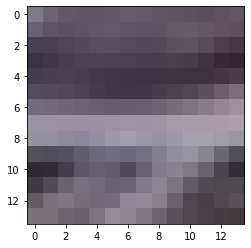

In [ ]:
from scipy import misc
import matplotlib.pyplot as plt


img = misc.face()
img = img[40:54, 50:64]
print(img.shape)
plt.imshow(img);

In [ ]:
from torchvision.transforms import ToTensor

img_tensor = ToTensor()(img)
img_tensor.shape

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:150: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


torch.Size([3, 14, 14])

In [ ]:
upsamle = nn.Upsample(scale_factor=(16, 16),
                      mode='bilinear',
                    #   mode='nearest',
                      )
# upsamle.weight

torch.Size([3, 224, 224])


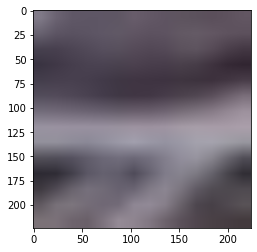

In [ ]:
upsamled_img = upsamle(img_tensor[None])[0]
print(upsamled_img.shape)
plt.imshow(upsamled_img.permute(1, 2, 0));

<table>
<tr>
<td><img src='https://drive.google.com/uc?export=view&id=10dBpbTIqysMVBeK-uw7-fjIaOaqGyivR' width=400>
</td>
<td>
<img src='https://drive.google.com/uc?export=view&id=1U9fe3rFasxK-kxwtWN_vOifynJgYEKPK' width=400>
</td>
</tr>
</table>

In [ ]:
conv = nn.ConvTranspose2d(in_channels=3,
                          out_channels=3,
                          stride=16,
                          kernel_size=16)
conv.weight.shape

torch.Size([3, 3, 16, 16])

torch.Size([3, 224, 224])


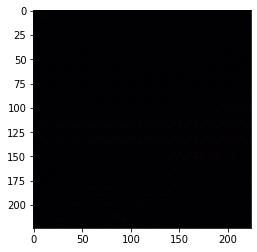

In [ ]:
conv_img = conv(img_tensor[None])[0].detach()
print(conv_img.shape)
plt.imshow(conv_img.permute(1, 2, 0));

### SegNet

SegNet появилась в 2015 г. Данная архитектура состоит из конволюционной и деконволюционной части. Она отчасти повторяет собой архитектуру Autoencoder, где есть кодирующая и декодирующая часть. 

Декодирующая часть в SegNet позволяет сделать более плавное разворачивание изображения после того как отработала сверточная часть архитектуры. Благодаря этому границы объектов на изображение определяются более корректно.

Стоит отметить, что в качестве сверточной части могут использоваться различные предтренерованные нейронные сети для решения задач классификации, например различные модификации VGG и ResNet.

<img src='https://drive.google.com/uc?export=view&id=1YRgQtgX90Y0YTuSRrDZfOr_qyEsVi6ax'>

### Unet

Когда мы изучаем задачу сегментацию, Unet - это одна из базовых и наиболее используемых моделей для сегментации. Есть очень много имплементаций Unet, но давайте разберемся с оригинальной Unet.
Ее архитектура представлена на картинке ниже.

<img src='https://drive.google.com/uc?export=view&id=1XbOyrbDKRIBde-phT8i6ctdJdRXmtLxZ' width=600>

Архитектура unet может быть разделена на левую (уменьшающую размерность картинки) и правую (увеличивающую) части.   
Левая часть - это сверточная сеть. Два 3х3 сверточных слоя следуют за активационной функцией Relu последовательно(Sequentially) и после этого применяется 2x2 maxpool слой (на картинке красная стрелка).   
В это время правая часть - то место где происходят действительно интересные вещи. Правая часть также имеет два 3х3 сверточных слоя, соединенные вместе (Sequentially), но нет привычных нам Relu активационной функции и MaxPool слоя. Вместо них зеленая стрелка на изображении. Проходя по расширяющему пути, мы будем брать изображение (копию) из левой части и комбинировать с изображением из правой (серая стрелка на изображении). Помните, что последовательные 3х3 сверточные слои также используются в правой части. Поэтому вход для них будет комбинацией с изображения из левой части и прошлого слоя (комбинация половин белой и голубой коробки в левой части изображения). Итог работы нейронной сети - это выходная сегментационная карта.


Особенность U-net - skip connection, похожие на те, что помогли решить проблему исчезающего градиента в задача классификации (ResNet архитектура). Данные skip connections позволяют сигналу не только проходить строго, сначала по нисходящей лестницы слоев, а потом по восходящей лестнице апсемплинга(увеличение маленькой репрезентации изображения в полноценную карту), но и также перескакивать между слоями одного уровня, что в частности решает проблему дублирования функций слоев и улучшает эффективность обучения.

<img src='https://drive.google.com/uc?export=view&id=1f3za1M3fCTbmze4DZIi5FQWgdmxzZQ9I' width=400>


### LinkNet
[Статья](https://arxiv.org/abs/1707.03718).

В этой архитектуре левая часть тоже не отличается от Unet. А в правой части вместо конкатенации идет суммирование, чтобы уменьшать количество обучаемых параметров. Из-за меньшего количества параметров данные нейронная сеть будет лучше справлять с real-time сегментацией.

<img src='https://drive.google.com/uc?export=view&id=1Je5xftoWKF2jtBy1O6Zg6NTgJsw87PeN' width=700>


### PSPNet
[GitHub. Pyramid Scene Parsing Network](https://github.com/Lextal/pspnet-pytorch)   
[Статья](https://arxiv.org/abs/1612.01105)
<img src='https://drive.google.com/uc?export=view&id=1p16XKLEV6zUa0m_WsuSxwVZN0h1g7yKD' width=800>

**Вопрос:** Почему у FCN не получается делать качественную сегментацию?


На изображении сравнение работы FCN и PSPNet, некоторые объекты сегментируются правильно, но относятся к неправильному классу. Это происходит из-за того, что у FCN недостаточно контекста картинки, чтобы понять, что перед ней лодка, а не машина, но глядя на контекст вокруге, можно понять, что если объект находится на воде, то вероятней всего это не машина, а лодка.


До этого брали один вектор, который вышел из энкодера и растягиваем его до размера исходной картинки, чтобы получить маску, теперь можем поделить карту с признаками на несколько регионов разных масштабов путем прохода через слой пулинга (в статье предлагают регионы масштабов 1x1, 2x2, 3x3 и 6x6), далее эти тензоры пропускаем через один слой свертки 1х1 для сжатия каналов, а затем сконкатенируем эти выходы с картой признаков (перед этим прогнав через слой апсемлинга, чтобы были одинаковые размерности) и сделаем привычную операцию деконволюций для получения маски.

<img src='https://drive.google.com/uc?export=view&id=1ghmtZa2vgmOWYRYXg6uuCfXGhLNF8y2t' width=1000>


### FPN
[Feature Pyramid Network](https://arxiv.org/abs/1901.02446)
В этой нейронной сети маски предсказываются не с последнего уровня, а с каждого, тем самым можно находить объекты разных масштабов с разных карт признаков.

<img src='https://drive.google.com/uc?export=view&id=1tyPhM_u6PtcTtnjlkO_SP3SXL25idrm3' width=500>

<img src='https://drive.google.com/uc?export=view&id=1QGUloAmSPCNW99MOfCjPQ4BERkrXLxCR'>

## Оценка качества

И конечно в любой сети нам нужна какая-то оценка качества наших моделей.

Обычно в задачах, решаемых с помощью нейронных сетей, настройка процесса обучения основывается большей частью на опыте исследователя и некоторых эвристиках. Например, для задач сегментации изображений чаще всего применяются функции потерь, основанные на оценке совпадения форм распознанных зон, так называемые Intersection over Union.

Интуитивно, основываясь на понимании поведения и результатах исследований, такого рода функции дадут лучший результат, чем те, которые не заточены под изображения, как например кросс-энтропийные. Тем не менее, эксперименты в поисках оптимального варианта для такого типа задач в целом и каждой задачи индивидуально продолжаются.

### Коэффициент DICE

* Dice может использоваться для попиксельного сравнения между предсказанной маской и истинной маской
* Dice - это площадь пересечения дважды, деленная на общее количество пикселей на двух картинках

<img src='https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png' width=200>

Формула подсчета:

<center> $ \huge \frac{2*|X∩Y|}{|X|+|Y|}$ </center>

<br>

где X - это предсказанное множество пикселей, а Y - истина.

### Intersection over Union

IoU - это мера величины перекрытия между двумя масками. Он вычисляет размер перекрытия между двумя объектами, деленный на общую площадь объединенных объектов.

<img src='https://drive.google.com/uc?export=view&id=1VcvjSTbx5JDZEpWzF-3bCeFFsAMVGyZS' width=500>


Формула подсчета:

<center> $ \huge \frac{|X∩Y|}{|X∪Y|}$ </center>

<br>

где X - это предсказанное множество пикселей, а Y - истина.

#<h1><center>Практическая часть</center></h1>

Что ж, перейдем от теории к практике. Давайте использовать PyTorch и закодим Unet, описание которой дано выше ([оригинальная статья](https://arxiv.org/pdf/1505.04597.pdf))

https://www.kaggle.com/julichitai/gb-segmentation-for-self-driving-cars-pytorch


## Домашнее задание

1. Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
2. Обучить модель на выбор из [segmentation_models_pytorch](https://segmentation-modelspytorch.readthedocs.io/en/latest/index.html)


## Дополнительные материалы

1. [Handwritten Text Segmentation](https://arxiv.org/pdf/1906.05229.pdf)
2. [Сегментация медицинских изображений](https://arxiv.org/abs/1505.04597)
3. [Рекуррентные нейронные сети для семантической обработки](https://imatge-upc.github.io/rsis/)
4. [Pyramid Scene Parsing Network](https://github.com/Lextal/pspnet-pytorch)
5. [Pyramid Scene Parsing Network | Lecture 32 (Part 3) | Applied Deep Learning](https://youtu.be/6fjsJT4gYnI)
6. [DeepLabV3](https://arxiv.org/abs/1706.05587)
7. [DeepLabv3+ | Lecture 32 (Part 4) | Applied Deep Learning](https://youtu.be/Gzrej8ciK9o)
8. [Mask-RCNN](https://kharshit.github.io/blog/2019/08/23/quick-intro-to-instance-segmentation)
9. [LinkNet](https://arxiv.org/abs/1707.03718)
10. [Feature Pyramid Network](https://arxiv.org/abs/1901.02446)
11. [Semantic Segmentation Benchmarks](https://paperswithcode.com/task/semantic-segmentation)

